# Importing Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Import Dataset

In [3]:
train_data = pd.read_csv('/content/drive/MyDrive/Datasets/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Datasets/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Datasets/sample_submission.csv')

In [4]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


# Dropping Irrelvent columns

In [7]:
cols_to_drop = ['PassengerId', 'Name']

# Drop from both train and test
train_data = train_data.drop(columns=cols_to_drop, errors='ignore')
test_data = test_data.drop(columns=cols_to_drop, errors='ignore')

Train Null Counts:
 HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
dtype: int64

Test Null Counts:
 HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
dtype: int64


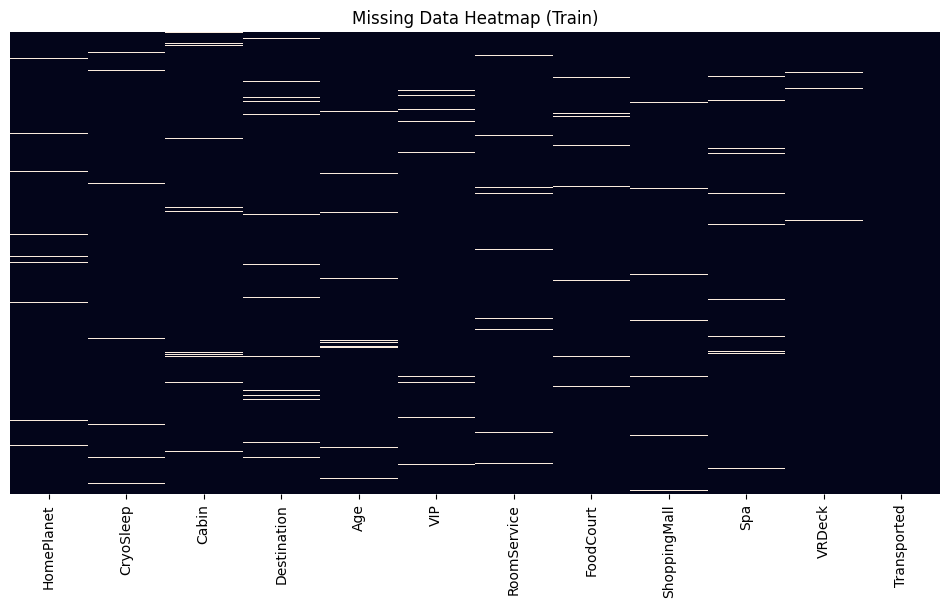

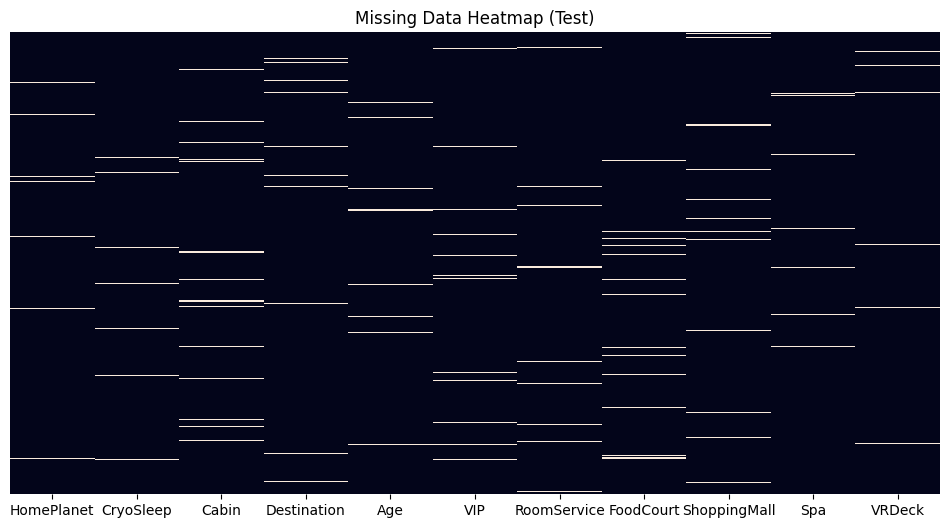

In [8]:
# Null analysis
print("Train Null Counts:\n", train_data.isnull().sum())
print("\nTest Null Counts:\n", test_data.isnull().sum())

# Plot missing values for train and test
plt.figure(figsize=(12,6))
sns.heatmap(train_data.isnull(), cbar=False, yticklabels=False)
plt.title('Missing Data Heatmap (Train)')
plt.show()

plt.figure(figsize=(12,6))
sns.heatmap(test_data.isnull(), cbar=False, yticklabels=False)
plt.title('Missing Data Heatmap (Test)')
plt.show()

# Imputing NULL Values using KNN

In [9]:
def encode_and_impute(train_data, test_data, cols_to_impute, cat_cols, n_neighbors=5):
    # --- Encode Categorical Columns ---
    train_copy = train_data.copy()
    test_copy = test_data.copy()
    encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        # Fit on non-null values from train only
        train_copy[col] = train_copy[col].astype(str)
        mask_train = train_data[col].notnull()
        le.fit(train_copy.loc[mask_train, col])
        encoders[col] = le
        # Use -1 for NaNs
        train_copy.loc[~mask_train, col] = -1
        # Transform (safe because -1 is not in training data)
        train_copy.loc[mask_train, col] = le.transform(train_copy.loc[mask_train, col])
        train_copy[col] = train_copy[col].astype(int)
        train_copy.loc[~mask_train, col] = -1  # make sure -1 for missing

        # For test data
        test_copy[col] = test_copy[col].astype(str)
        mask_test = test_data[col].notnull()
        test_copy.loc[~mask_test, col] = -1
        # Only transform values seen in train, unknowns to -1
        # Map values not in le.classes_ to -1
        test_copy.loc[mask_test, col] = test_copy.loc[mask_test, col].map(
            lambda x: le.transform([x])[0] if x in le.classes_ else -1
        )
        test_copy[col] = test_copy[col].astype(int)
        test_copy.loc[~mask_test, col] = -1

    # --- Ensure numeric ---
    for col in cols_to_impute:
        train_copy[col] = pd.to_numeric(train_copy[col], errors='coerce')
        test_copy[col] = pd.to_numeric(test_copy[col], errors='coerce')

    # --- Fit KNN Imputer on train, transform both ---
    imputer = KNNImputer(n_neighbors=n_neighbors)
    imputer.fit(train_copy[cols_to_impute])
    train_imputed = imputer.transform(train_copy[cols_to_impute])
    test_imputed = imputer.transform(test_copy[cols_to_impute])

    train_imputed_df = pd.DataFrame(train_imputed, columns=cols_to_impute, index=train_copy.index)
    test_imputed_df = pd.DataFrame(test_imputed, columns=cols_to_impute, index=test_copy.index)

    # --- Decode categorical columns ---
    for col in cat_cols:
        le = encoders[col]
        train_imputed_df[col] = train_imputed_df[col].round().astype(int)
        test_imputed_df[col] = test_imputed_df[col].round().astype(int)
        # Clip negative values to 0 to avoid decode errors
        train_imputed_df[col] = np.where(train_imputed_df[col] < 0, 0, train_imputed_df[col])
        test_imputed_df[col] = np.where(test_imputed_df[col] < 0, 0, test_imputed_df[col])
        train_imputed_df[col] = le.inverse_transform(train_imputed_df[col])
        test_imputed_df[col] = le.inverse_transform(test_imputed_df[col])

    # --- Assign back to main dataframes ---
    for col in cols_to_impute:
        train_data[col] = train_imputed_df[col]
        test_data[col] = test_imputed_df[col]

    return train_data, test_data

# Usage
cols_to_impute = [
    'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
    'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'
]
cat_cols = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP']

train_data, test_data = encode_and_impute(train_data, test_data, cols_to_impute, cat_cols, n_neighbors=5)

# Check
print(train_data[cols_to_impute].isnull().sum())
print(test_data[cols_to_impute].isnull().sum())

HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64
